# Lecture 7: Introduction to Probability Theory (Part IV)

## Objectives

+ Introduce pseudo-random number generators (PRNG).
+ Demonstrate how we can sample from the uniform distribution using PRNGs.
+ Demonstrate how we can sample from the Bernoulli using uniform samples.
+ Demonstrate how we can sample from arbitrary discrete distributions using uniform samples.
+ Demonstrate the central limit theorem and the natural rise of the Gaussian distribution.
+ Demonstrate how we can sample from univariate continuous distributions using uniform samples (inverse transform sampling, rejection sampling).

## Readings

+ These notes.
+ [Middlesquare algorithm](https://en.wikipedia.org/wiki/Middle-square_method).
+ [Linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator).
+ [Empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function).
+ [The central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).
+ [Characteristic functions](https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)).
+ [Inversion transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling).
+ [Rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling).

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import numpy as np

## Pseudo-random number generators (PRNG)

Random number generation is the backbone of Bayesian inference.
Computers are deterministic.
So, how can they generate random numbers?
Well they cannot!
But they can produce sequence of numbers that look like random numbers!
These "fake" random number generators are called Pseudo-random number generators (PRNG).
They are used to generate random numbers between zero and a maximum integer, say $m$.
As we will argue later this is sufficient to generate pretty much any random variable you want.

### The middlesquare algorithm (Von Neumann)

The [middlesquare algorithm](https://en.wikipedia.org/wiki/Middle-square_method) is the simplest PRNG.

1. Take a number and square it.
2. Pad the result with zeros to get to the desired number of digits.
3. Take the middle digits of the resulting number.
4. Repeat.

Here is an implementation:

In [ ]:
def middlesquare(s, digits=4):
    """
    :param s:      The initial seed.
    :param digits: How many digits do you want.
    """
    # Square the number
    s2 = s ** 2
    # Turn the resulting number into a string padding with zeros to get to the desired number of digits
    s2_str = str(s2).zfill(2*digits)
    # Keep only the middle
    middle_str = s2_str[int(np.floor(digits/2)):][:-int(np.floor(digits/2))]
    return int(middle_str)

Let's draw some random numbers:

In [1]:
seed = 1234
s = seed
for _ in range(20):
    s = middlesquare(s, digits=4)
    print(s)

NameError: name 'middlesquare' is not defined

Unfortunately, the middlesquare algorithms results in periodic sequences with very small period. For example:

In [4]:
seed = 540
s = seed
for _ in range(20):
    s = middlesquare(s, digits=4)
    print(s)

2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540


### Linear congruential generator (LCG)
The [linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator) works as follows. You pick three big integers $a$, $b$ and $m$.
Pick a seed $x_0$.
Then iterate:
$$
x_{i+1} = (a x_i + b)\mod m
$$

Here is a simple implementation:

In [5]:
def lcg(x, a=123456, b=978564, m=6012119):
    """
    :param x: The previous number in the sequence.
    :param a: A big integer.
    :param b: Another big integer.
    :param m: Another big integer.
    """
    return (a * x + b) % m

In [7]:
# Let's draw some random numbers:
seed = 1234
s = seed
for _ in range(20):
    s = lcg(s)
    print(s)

3020293
2650792
5494308
965075
3115541
1883116
317849
243995
2909094
134725
4067010
1658958
451558
4155644
2001482
3861575
4605659
1061643
2982572
5159241


The good thing about LCG is that you can prove a lot of stuff about it using group theory and that you know that the maximum possible number is $m-1$.
That is, you know that it gives you numbers between 0 and $m-1$.

### Mersenne Twister PRNG
Numpy uses the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) to generate random numbers.
Its details are more complicated than LCG, but it is still initialized by an integer seed.
You can test it as follows:

In [8]:
# set the seed
np.random.seed(12345)
# print 5 integers from 0 to 6012119
for _ in range(5):
    print(np.random.randint(0, 6012119))

1396132
2993577
1134974
5664101
3555874


In [6]:
# see what the seed does - Here is what happens if you rerun the code above:
for _ in range(5):
    print(np.random.randint(0, 6012119))

775836
2248498
5689798
5181908
4395687


In [9]:
# And here is what happens if you reset the seed to its original value and rerun the code
np.random.seed(12345)
for _ in range(5):
    print(np.random.randint(0, 6012119))

1396132
2993577
1134974
5664101
3555874


So, resetting the seed gives you the same sequence. In your numerical simulations you should always set the seed by hand in order to ensure the reproducibility of your work.

## Sampling from the uniform distribution

If we have a PRNG that samples between zero and a big integer, say $m$, we can create a generator that samples from the uniform distribution.
If $d$ is the sample from the PRNG, then
$$
x = \frac{d}{m},
$$
is approximately uniformly distributed.
Let's experiment with this idea.

In [10]:
# The maximum integer
m = 6012119

# First a uniform random generator based on lcg
lcg_seed = 123456 # A seed of lcg
lcg_state = lcg_seed # Internal state of lcg
def unif_lcg():
    """
    Samples from the uniform using LCG.
    """
    global lcg_state
    lcg_state = lcg(lcg_state)
    return lcg_state / (1. * m) # The 1. in the denominator ensures
                                # that the division is done in floating point arithmetic
print('LCG Uniform Samples:')
for _ in range(5):
    print(unif_lcg())

# And let's also do it with Mersenne Twister from numpy
np.random.seed(123456)
def unif_mt():
    """
    Samples from the uniform using the MT.
    """
    return np.random.randint(0, m) / (1. * m)
print('\nMT Uniform Samples:')
for _ in range(5):
    print(unif_mt())

LCG Uniform Samples:
0.27292124457283695
0.9279352255003602
0.3339646138075444
0.09812746554085174
0.5871510527319902

MT Uniform Samples:
0.011933396527913037
0.8868237638010824
0.5074856302744507
0.5300725085448242
0.5373225313737137


Which one of the two is better? There are many statistical tests that we would like our uniform random number generator to go through. First (and most importantly) the empirical histograms of the generated numbers should be uniform. Let's test this.

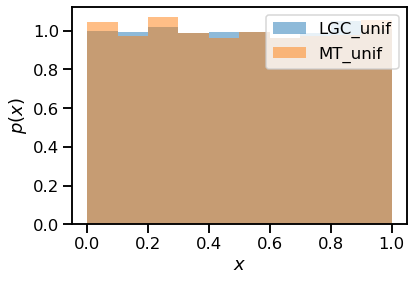

In [11]:
# How many numbers to sample:
N = 10000
lcg_X = [unif_lcg() for _ in range(N)]
mt_X = [unif_mt() for _ in range(N)]
# Plot the histograms
fig, ax = plt.subplots()
ax.hist(lcg_X, density=True, alpha=0.5, label='LGC_unif')
ax.hist(mt_X, density=True, alpha=0.5, label='MT_unif')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.legend(loc='best');

This was a rough visual test.
We can do better.
We can compare the [empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function) of each one of these algorithms with the ideal CDF, i.e., that of a real uniform.
But what is the empirical CDF of a bunch of samples $x_{1:N}$?
It is defined as follows:
$$
\hat{F}_N(x) = \frac{\text{number of elements in sample}\;\le x}{N} = \frac{1}{N}\sum_{n=1}^N 1_{(-\infty, x_i]}(x).
$$
Let's implement this:

In [12]:
def ecdf(x):
    """
    The empirical distribution function of scalar samples.
    
    From: https://stackoverflow.com/questions/15792552/numpy-scipy-equivalent-of-r-ecdfxx-function
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

Now, let's plot the empirical CDF of each of the samples and plot it against $F(x) = x$ (the tru CDF of the uniform).

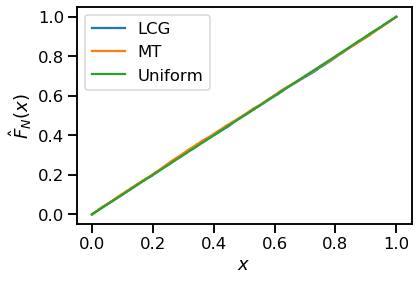

In [13]:
fig, ax = plt.subplots()
ax.plot(*ecdf(lcg_X), label='LCG')
ax.plot(*ecdf(mt_X), label='MT')
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label='Uniform')
ax.set_xlabel('$x$')
ax.set_ylabel('$\hat{F}_N(x)$')
plt.legend(loc='best');

This is still visual. The [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) summarizes calculate a distance between the empirical distribution and the ideal one.
It is defined as follows:
$$
D_N = \sup_x |F(x) - \hat{F}_N(x)|,
$$
where (if you don't know what it is) you can think of the supremum ($\sup$) as just the maximum.
In other words, $D_N$ is the maximum absolute difference between $F(x)$ and $\hat{F}_N(x)$.
Let's see what we get for LCG and MT compared to the uniform:

In [14]:
import scipy.stats as st
D_lcg, p_val_lcg = st.kstest(lcg_X, 'uniform')
D_mt, p_val_mt = st.kstest(mt_X, 'uniform')
print('KS statistic for LCG vs uniform: {0:1.2f}'.format(D_lcg))
print('KS statistic for MT vs uniform: {0:1.2f}'.format(D_mt))

KS statistic for LCG vs uniform: 0.01
KS statistic for MT vs uniform: 0.01


### Question
+ Hmm, we probably need to increase the number of samples to observe this statistic better. Increase $N$ from 100 to $1,000$ and then to $10,000$. How do the distributions look like now?
    * The distribution get closer and closer  to the `uniform` distribution

+ A second thing that we would like to test is whether or not consecutive numbers are all independent (Idependent identically distributed). Unfortunately, we need more theory than we know to do this.

+ For future reference, note that you should not really use ``unif_mt`` to generate uniform random numbers. Numpy already implements this in ``numpy.random.rand``. We provide an example right below. 

In [15]:
# Generate some random numbers with numpy's unif_mt:
X = np.random.rand(10)
print(X)

[0.65756026 0.94159346 0.67447773 0.14473644 0.94071317 0.74537353
 0.19962343 0.71038216 0.31567267 0.94036825]


## Example: Sampling the Bernoulli distribution
The Bernoulli distribution arises from a binary random variable representing the outcome of an experiment with a given probability of success.
Let us encode success with 1 and failure with 0.
Then, we say that the random variable
$$
X\sim \operatorname{Bernoulli}(\theta),
$$
is a Bernoulli random variable with parameter $\theta$ if:
$$
X = \begin{cases}
1,\;\text{with probability}\;\theta,\\
0,\;\text{otherwise}.
\end{cases}
$$
Another way to write the same thing is through the probability density function of $X$:
$$
p(x) = \theta \delta(x-1) + (1-\theta)\delta(x),
$$
where we used Dirac's delta to talk about point masses.
To sample from it, we do the following steps:

+ Sample a uniform number $u$ (i.e., a number of $\mathcal{U}([0,1])$).

+ If $u\le \theta$, then set $x = 1$.

+ Otherwise, set $x = 0$.

Let's see if this process does indeed produce the desired result.

In [16]:
def sample_bernoulli(theta):
    """
    Samples from the Bernoulli.
    """
    u = np.random.rand()
    if u <= theta:
        return 1
    return 0

for _ in range(10):
    print(sample_bernoulli(0.5))

1
0
0
1
0
0
0
1
0
0


Text(0, 0.5, '$p(x)$')

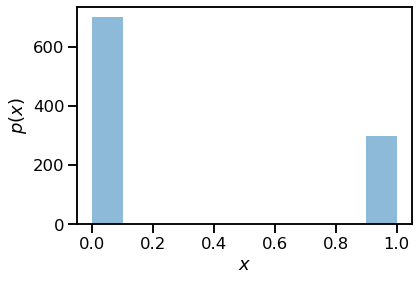

In [17]:
# Let's do a histogram like before
N = 1000
X = [sample_bernoulli(0.3) for _ in range(N)]
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

Ok, it looks fine. About $\theta N$ samples went to 1 and $(1-\theta)N$ samples went to 0.

Of course, we have already seen that this is implemented in scipy.stats.
Here is a quick reminder of that code.

In [18]:
X = st.bernoulli(0.3)
X.rvs(size=10)

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1])

## Sampling discrete distributions
Consider a generic discrete random variable $X$ taking $K$ different values.
Without loss of generality, you may assume that these values are integers $\{0, 1,2,\dots,K-1\}$ (they are just the labels of the discrete objects anyway).
Let us assume that
$$
p(X=k) = p_k,
$$
where, of course, we must have:
$$
p_k \ge 0,
$$
and
$$
\sum_{k=0}^{K-1} p_k = 1.
$$
Remember, that an succinct way to write this is using the Dirac delta:
$$
p(x) = \sum_{k=0}^{K-1}p_k\delta(x-k).
$$
In any case, here is how you sample from such a distribution:

+ Draw a uniform sample $u$.
+ Find the index $j\in\{0,1,\dots,K-1\}$ such that:
$$
\sum_{k=0}^{j-1}p_k \le u < \sum_{k=0}^jp_k.
$$
+ Then, your sample is $j$.

Let's code it.

In [19]:
def sample_discrete(p):
    """
    Sample from a discrete probability density.
    
    :param p: An array specifying the probability of each possible state.
              The number of states ``m=len(p)``.
    :returns: A random integer.
    
    (btw this is how you document a python function)
    """
    K = len(p)
    u = np.random.rand()
    c = 0.
    for j in range(K):
        c += p[j]
        if u <= c:
            return j

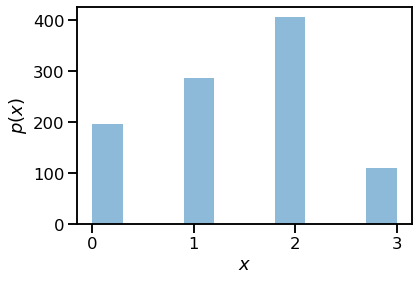

In [20]:
# Let's test it with a four-state discrete random variable with probabilities
p = [0.2, 0.3, 0.4, 0.1]
# Let's take 1,000 samples
N = 1000
X = [sample_discrete(p) for _ in range(N)]
# and do the empirical histrogram
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$');

Of course, numpy already implements this functionality. Here is how to do the same thing numpy:

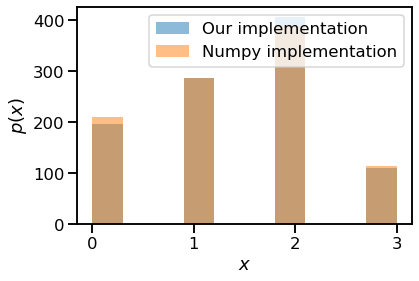

In [21]:
X_np = np.random.choice(np.arange(4), # The objects that you want to sample (here integers, 0,1,2,3)
                        p=p,          # The probability of sampling each object
                        size=N        # How many samples you want  
                       )
# Let's compare the two histograms
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5, label='Our implementation')
ax.hist(X_np, alpha=0.5, label='Numpy implementation')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.legend(loc='best');

And it is also possible to do it using a Categorical random variable from scipy:

In [22]:
X_st = st.rv_discrete(values=(np.arange(4), p))
X_st.rvs(size=100)

array([2, 0, 2, 3, 1, 1, 2, 2, 1, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 1, 2, 1,
       3, 3, 1, 1, 3, 1, 0, 2, 1, 2, 1, 1, 3, 2, 1, 3, 1, 0, 1, 0, 2, 0,
       0, 2, 0, 0, 0, 3, 2, 0, 0, 2, 3, 2, 2, 1, 1, 0, 1, 2, 1, 3, 1, 1,
       0, 2, 1, 3, 0, 3, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 0, 1, 3, 0])

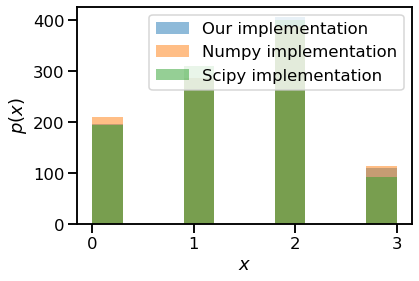

In [23]:
# Let's compare the three histograms
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5, label='Our implementation')
ax.hist(X_np, alpha=0.5, label='Numpy implementation')
ax.hist(X_st.rvs(size=N), alpha=0.5, label='Scipy implementation')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.legend(loc='best');

## Example: The Binomial distribution for large $N$

The Binomial distribution gives you the number of successes in $N$ tries of a random experiment with probability of success $\theta$.
We write:
$$
X\sim B(N,\theta).
$$
You can easily simulate it (excersize) by noticing that:
$$
X = \sum_{i=1}^N X_i,
$$
where
$$
X_i \sim B(\theta),
$$
are indepdent Bernoulli trials.
We can also show that:
$$
p(X=k) = \left(\begin{array}{c}N\\ k\end{array}\right)\theta^k(1-\theta)^{N-k}.
$$
Let's plot this distribution for various $N$'s.
We will use the built-in ``scipy.stats`` functionality for this one.
For your future reference, you can find it [here](https://docs.scipy.org/doc/scipy/reference/stats.html).

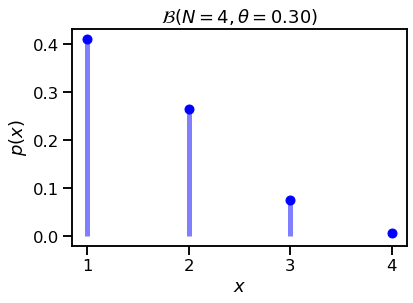

In [24]:
import scipy.stats as st

def plot_binom_pdf(N, theta):
    k = np.arange(N) + 1. # From 1 to N
    p_k = st.binom(N, theta).pmf(k) # pmf is short for probability mass function
                                    # which is the right terminology for a discrete variable
                                    # (i.e., we use 'mass' instead of 'density')
    fig, ax = plt.subplots()
    ax.plot(k, p_k, 'o', color='b')
    ax.vlines(k, 0, p_k, colors='b', lw=5, alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_title(r'$\mathcal{B}(N=%d, \theta=%.2f)$' % (N, theta)) # the 'r' is required to render
                                                                   # '\' character correctly
    
plot_binom_pdf(4, 0.3)

Ok, now let's play with $N$.

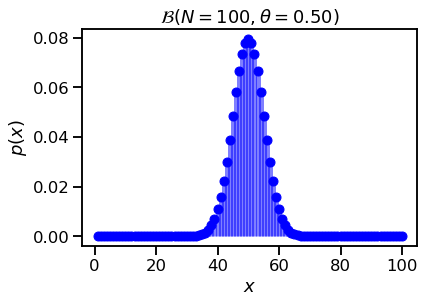

In [25]:
plot_binom_pdf(100, 0.5)

### Question
+ Start increasing $N$. Try really big numbers. Does the result remind you a familiar distribution?
    * Yes, to normal (gaussian) distribution
+ Play a little bit with $\theta$. What happens as you move it around?

## The central limit theorem (CLT)
Consider, $X_1,X_2,\dots$ be iid random variables with mean $\mu$ and variance $\sigma^2$.
Define their sum:
$$
S_N = \frac{X_1+\dots+X_N}{N}.
$$
The Central Limit Theorem (CLT), states that:
$$
S_N \sim \mathcal{N}(S_N|\mu, \frac{\sigma^2}{N}),
$$
for large $N$.
That is, they start to look like Gaussian.
Let's test it for the Exponential distribution.
We will use ``numpy.random.exponential`` to sample from the exponential.

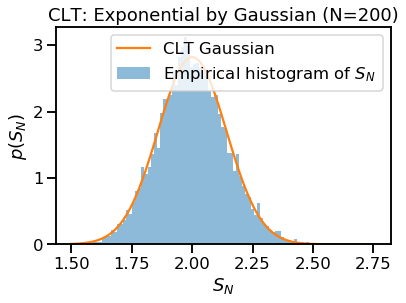

In [26]:
r = 0.5
N = 200   # How many iid variables are we going to sum
M = 10000 # How many times do you want to sample
Ts = np.random.exponential(scale=1./r, size=(N, M))  # Notice that it uses the inverse of the rate.
                                                     # It is always a good idea to look at the documentation
                                                     # if you are unsure.
# These are the samples of SN:
SN = np.sum(Ts, axis=0) / N  # Notice that I am only summing the rows

fig, ax = plt.subplots()
ax.hist(SN, bins=100, density=True, alpha=0.5, label='Empirical histogram of $S_N$')
mu_CLT = 1. / r             # CLT mean
sigma_CLT = np.sqrt(1. / (N * r**2)) # CLT standard deviation
Ss = np.linspace(SN.min(), SN.max(), 100)
ax.plot(Ss, st.norm(loc=mu_CLT, scale=sigma_CLT).pdf(Ss), label='CLT Gaussian')
ax.set_xlabel('$S_N$')
ax.set_ylabel('$p(S_N)$')
ax.set_title('CLT: Exponential by Gaussian (N=%d)' % N)
plt.legend(loc='best');

### Questions

+ Start increase $N$ and observe the convergence.
+ Go back to the Bernoulli distribution. What are its mean and variance? What is the mean and the variance of the Gaussian approximating the sum of idenpdent Bernoulli distributions? Verify this result numerically (copy paste the code above and make the appropriate changes).
    * Theroretically for Bernoulli distrubtion:
        * $\mu = \theta$
        * $\mathbb{V} = \theta(1-\theta)$

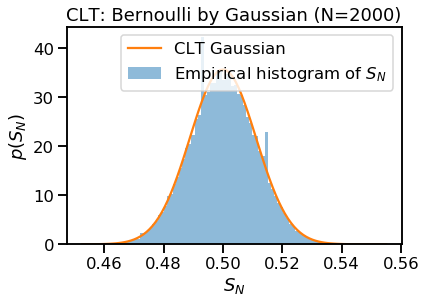

In [70]:
# Bernoulli Distribution
theta = 0.5
N = 2000   # How many iid variables are we going to sum
M = 100000 # How many times do you want to sample
# X = st.bernoulli(theta) 
Ts = np.random.binomial(n=1,p=theta,size=(N, M))  # Notice that it uses the inverse of the rate.
                                                  # It is always a good idea to look at the documentation
                                                  #  if you are unsure.
# print(Ts)
# These are the samples of SN:
SN = np.sum(Ts, axis=0) / N  # Notice that I am only summing the rows
# print(SN)
fig, ax = plt.subplots()
ax.hist(SN, bins=100, density=True , alpha=0.5, label='Empirical histogram of $S_N$')
mu_CLT = theta                 # CLT mean
sigma_CLT = np.sqrt(1.* theta*(1-theta)/ (N)) # CLT standard deviation
Ss = np.linspace(SN.min(), SN.max(), 100)
ax.plot(Ss, st.norm(loc=mu_CLT, scale=sigma_CLT).pdf(Ss), label='CLT Gaussian')
ax.set_xlabel('$S_N$')
ax.set_ylabel('$p(S_N)$')
ax.set_title('CLT: Bernoulli by Gaussian (N=%d)' % N)
plt.legend(loc='best');

## A simple proof of the central limit theorem

The proof of the CLT is surprisingly simple.
It goes as follows:
+ Take the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) of the PDF of
$$
Z_N = \frac{X_1 + \dots + X_N - N\mu}{\sqrt{N}\sigma}.
$$
+ Take the limit of $N\rightarrow +\infty$.
+ Compare what you find to the Fourier transform of the PDF of the standard normal $Z\sim N(0,1)$.

Note: The Fourier transform of the PDF of a random variable is called the [characteristic function](https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)) of the random variable.

Ok, let's start with the PDF of the standard normal $Z\sim N(0,1)$ so that we know what we should expect to find.
The PDF of the standard normal is:
$$
\phi(z) = \frac{1}{\sqrt{2\pi}}\exp\left\{-\frac{z^2}{2}\right\}.
$$
We have (we just looked it up in Fourier transform table):
$$
\hat{\phi}(t) = \int_{-\infty}^{+\infty} e^{itz}\phi(z)dz \equiv \mathbb{E}\left[e^{itZ}\right] = e^{-\frac{t^2}{2}}.
$$
Notice that the Fourier transform is nothing more than an expectation.
This notation is very convenient.

Now, let's work on the fourier transform of the PDF of $S_N$:
$$
\begin{split}
\hat{p}_{Z_N}(t) &=& \mathbb{E}\left[e^{tZ_N}\right]\;\text{(definition)}\\
&=& \mathbb{E}\left[e^{t\frac{X_1+\dots+X_N-N\mu}{\sqrt{N}\sigma}}\right]\;\text{(definition)}\\
&=& \prod_{n=1}^N \mathbb{E}\left[e^{t\frac{X_n-\mu}{\sqrt{N}\sigma}}\right]\;\text{(independent r.v.)}\\
&=& \prod_{n=1}^N \hat{p}_{Y_n}\left(\frac{t}{\sqrt{N}}\right);\text{(FT definition)}\\
&=& \left[\hat{p}_{Y_1}\left(\frac{t}{\sqrt{N}}\right)\right]^N\;\text{(identical dist. r.v.)}\\
&=& \left[\hat{p}_{Y_1}(0) + \frac{t}{\sqrt{N}}\hat{p}_{Y_1}'(0) + \frac{t^2}{2N}\hat{p}_{Y_1}''(0) + \dots\right]^N\;\text{(Taylor expansion)}\\
&=& \left[1 + \frac{t}{\sqrt{N}}\cdot 0 + \frac{t^2}{2N}\cdot(-1) + \dots\right]^N\;\text{(see below)}\\
&=& \left[1 - \frac{t^2}{2N} + \dots\right]^N
\end{split}
$$
where we have defined the centered and normalized random variables:
$$
Y_n = \frac{X_n - \mu}{\sigma},
$$
and we used the fact that:
$$
\hat{p}_{Y_n}(0) = \mathbb{E}\left[e^{itY_n}\right]|_{t=0} = 1,
$$
$$
\hat{p}_{Y_n}'(0) = \left\{\mathbb{E}\left[e^{itY_n}\right]\right\}'|_{t=0} = \mathbb{E}\left[iY_ne^{itY_n}\right]|_{t=0} = i \mathbb{E}[Y_n] = 0,
$$
and
$$
\begin{split}
\hat{p}_{Y_n}''(0) &=& \left\{\mathbb{E}\left[e^{itY_n}\right]\right\}''|_{t=0}\\
&=& \left\{\mathbb{E}\left[iY_ne^{itY_n}\right]\right\}'|_{t=0}\\
&=& \left\{\mathbb{E}\left[i^2Y_n^2e^{itY_n}\right]\right\}'|_{t=0}\\
&=& -\mathbb{E}[Y_n^2]\\
&=& -1.
\end{split}
$$

Finally, we can take the limit $N\rightarrow+\infty$ to get:
$$
\hat{p}_{Z_N}(t) = \left[1 - \frac{t^2}{2N} + \dots\right]^N\rightarrow e^{-\frac{t^2}{2}}.
$$

## Inverse sampling
How do you sample an arbitrary univariate continuous random variable $X$ with CDF $F(x)$.
In this scenario, *inverse sampling* is the way to go.
It relies on the observation that the random variable
$$
Y = F^{-1}(U),
$$
where $F^{-1}$ is the inverse of the CDF of $X$ and $U\sim\mathcal{U}([0,1])$ has exactly the same distribution as $X$.

We will demonstrate this by example. To this end, let us consider an [exponential random variable](https://en.wikipedia.org/wiki/Exponential_distribution):
$$
T \sim E(r),
$$
where $r > 0$ is known as the *rate parameter*.
The exponential distribution describes the time it passes between random events that occur at a constnat rate $r$.
Its PDF is:
$$
p(t) = re^{-rt},
$$
and its CDF is:
$$
F(t) = p(T\le t) = 1 - e^{-rt}.
$$
We plot it next.

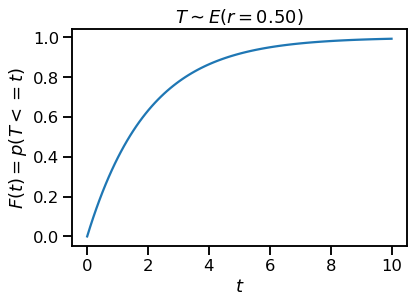

In [32]:
r = .5 # Events occur every 0.5 minutes
fig, ax = plt.subplots()
t = np.linspace(0., 5. / r, 100)
ax.plot(t, st.expon(scale=1./r).cdf(t))
ax.set_xlabel('$t$')
ax.set_ylabel(r'$F(t) = p(T <= t)$')
ax.set_title(r'$T\sim E(r=%.2f)$' % r);

To sample $T$ using inverse sampling, we need the inverse of the CDF. This is easily shown to be:
$$
F^{-1}(u) = -\frac{\ln(1-u)}{r}.
$$
Let's see if this is going to give us the right samples.
We will compare the empirical histogram obtained by inverse sampling to the actual PDF $p(t)$.

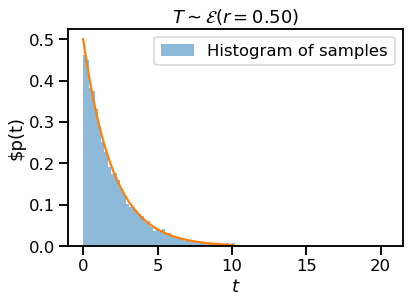

In [33]:
def sample_exp(r):
    u = np.random.rand()
    return -np.log(1. - u) / r

N = 10000
T = [sample_exp(r) for _ in range(N)]
fig, ax = plt.subplots()
ax.hist(T, alpha=0.5, density=True, bins=100, label='Histogram of samples')
ax.plot(t, st.expon(scale=1./r).pdf(t))
ax.set_xlabel('$t$')
ax.set_ylabel('$p(t)')
ax.set_title(r'$T\sim\mathcal{E}(r=%.2f)$' % r)
plt.legend(loc='best');

### Questions

+ Implement inverse sampling for a univariate Gaussian with zero mean and unit variance. Use ``scipy.stats`` to find the inverse CDF of the Gaussian (It is ``st.norm.ppf``).

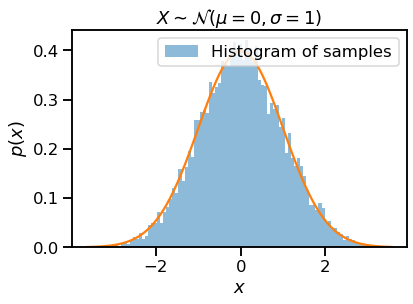

In [52]:
# Inverse sampling for a univariate Gaussian with zero mean and unit variance
def sample_norm(mu,sigma):
    X = st.norm(loc=mu, scale=sigma) #Normal (Gaussian) random variable
    u = np.random.rand()
    return X.ppf(u) # Percent point function (inverse of cdf — percentiles)

N = 10000
mu = 0
sigma = 1
X = [sample_norm(mu,sigma) for _ in range(N)]
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5, density=True, bins=100, label='Histogram of samples')
x = np.linspace(min(X), max(X), 100)
ax.plot(x, st.norm(loc=mu,scale=sigma).pdf(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_title(r'$X\sim\mathcal{N}(\mu=%.0f,\sigma=%.0f)$' % (mu,sigma))
plt.legend(loc='best');

## Rejection sampling

Rejection sampling is a method that allows us to sample from a PDF of a scalar random variable even if we do not know its normalization constant.
That is, we can use it to sample from a PDF of the form:
$$
p(x) = \frac{\pi(x)}{Z},
$$
where $Z$ is not explicitly known.
How does it work?
The basic ingredient is another PDF, say $q(x)$, for each we can show that:
$$
M q(x) \ge \pi(x),
$$
for some constant $M$ and from which we can easily sample.
Instead of introducing the method theoretically, let's introduce it via an specific example.

### Example: Using rejection sampling to sample from the beta distribution

The PDF of the Beta is:
$$
p(x) \propto x^{\alpha-1}(1-x)^{\beta - 1}1_{[0,1]}(x),
$$
for some $\alpha$ and $\beta$ positive.
Of course, in this case, we do know the normalization constant but let's pretend that we don't know it.
We need to find a PDF $q(x)$ from which we can easily sample and a constant $M$ so that the inequality we introduced above is satisfied.
Let's take the PDF of the uniform:
$$
q(x) = 1_{[0,1]}(x).
$$
How can we find the desired constant.
We want to have:
$$
\begin{split}
M q(x) &\ge& \pi(x)\\
M &\ge& \frac{\pi(x)}{q(x)}\\
M &\ge& x^{\alpha-1}(1-x)^{\beta - 1}1_{[0,1](x)} = h(x).
\end{split}
$$
So, $M=1$ always works because $x$ is in $[0,1]$.
We can also find a smaller $M$ by using a little bit of calculus, but we are not going to bother.

Alright. Nothing so far.
You will see the idea of rejection sampling once we draw the following graph.

I am using M = 0.01


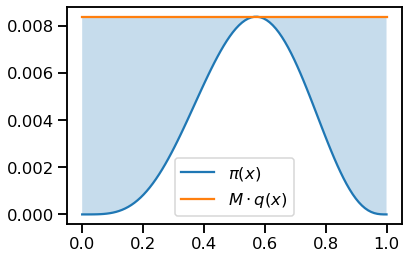

In [81]:
a = 5
b = 4
pi = lambda x: x ** (a - 1.0) * (1.0 - x) ** (b - 1.0)
q = lambda x: np.ones_like(x)
xs = np.linspace(0, 1, 100)
M = np.max(pi(xs))
# print('I am using M = {0:1.2f}'.format(M))
print(f'I am using M = {M:0.2f}')
fig, ax = plt.subplots()
ax.plot(xs, pi(xs), label='$\pi(x)$')
ax.plot(xs, M * q(xs), label='$M\cdot q(x)$')
# Let's also color the region between 
ax.fill_between(xs, pi(xs), M * q(xs), alpha=0.25)
plt.legend(loc='best');

Here is the idea:
+ We sample a point inside the area specified by $M\cdot q(x)$.
+ If we hit the white area, we keep the sample and go to the next step
Otherwise, we reject the sample, and go to the first step.
+ The $x$-coordinate of the accepted sample is a sample from $p(x)$.

Let's try it out.

In [82]:
# Number of samples to take:
num_samples = 1000
# An array to store the samples
x_rs = np.ndarray((num_samples,))
# Start sampling
for n in range(num_samples):
    # Keep sampling until a sample is accepted
    while True:
        # Sample a point in the 2D domain defined by M * q(x)
        # x coordinate comes by sampling q(x) (which is uniform here)
        x_c = np.random.rand()
        # y coordinate comes by sampling a number between 0 and M * q(x_c)
        y_c = M * q(x_c) * np.random.rand()
        # Test if we are above or below pi(x_c)
        if y_c <= pi(x_c):
            # The sample is accepted, break the loop
            break
        # The sample is rejected. The loop will be repeated.
    x_rs[n] = x_c

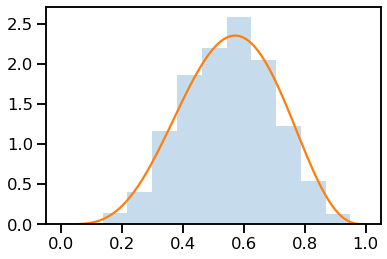

In [83]:
# Let's plot the hist of the samples we just got and compare it to the PDF of the Beta
fig, ax = plt.subplots()
ax.hist(x_rs, density=True, alpha=0.25)
ax.plot(xs, st.beta(a, b).pdf(xs))

### Questions

+ Rerun the rejection sampling algorithm above for different $\alpha$ and $\beta$.